In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates


In [ ]:
xls = pd.ExcelFile('stock_data.xlsx')

# Now you can list all sheets in the file
xls.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

Data Exploration

Here we are taking the first dataset which is Russia.

In [ ]:
df_russia = pd.read_excel(xls, 'Russia - Sberbank Rossii PAO (S')

In [ ]:
df_russia.shape

(312, 7)

In [ ]:
df_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [ ]:
df_russia.tail()

,Date,Price,Open,High,Low,Vol.,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [ ]:
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB


Trade does not happen everyday like holidays so some data are missing

In [ ]:
df_russia.describe()

,Change %
count,311.000000
mean,0.000668
std,0.021931
min,-0.095700
25%,-0.010100
50%,0.000400
75%,0.012950
max,0.129000


Data Preprocessing

As you can see the last row is not really the data. so it is dropped.

In [ ]:
#Drop the last row
df_russia.drop(df_russia.shape[0]-1, axis = 0, inplace=True)

In [ ]:
df_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


We are keeping the date as the index.

In [ ]:
df_russia['Date'] = pd.to_datetime(df_russia.Date, format = "%Y-%m-%d")
df_russia=df_russia.set_index(['Date'])
df_russia.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294,294.42,290.26,47.00M,-0.0076
2021-03-30,293.25,294.86,295.72,291.5,38.81M,-0.0002
2021-03-29,293.3,289.72,294.09,289.26,43.68M,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159
2021-03-25,286.66,286.5,287.03,283.85,35.22M,0.0030


Making every features to float datatype for making for good analysis.

In [ ]:
df_russia=df_russia.astype({'Price':'float','Open':'float','High':'float','Low':'float'})
print(df_russia.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %    float64
dtype: object


In [ ]:
df_russia.describe()

,Price,Open,High,Low,Change %
count,311.000000,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141,0.000668
std,32.079847,32.058167,32.075624,32.076603,0.021931
min,174.270000,175.000000,182.200000,172.150000,-0.095700
25%,207.700000,207.215000,209.660000,204.475000,-0.010100
50%,229.140000,229.080000,231.950000,226.860000,0.000400
75%,264.380000,263.885000,267.255000,261.110000,0.012950
max,293.300000,294.860000,296.070000,291.500000,0.129000


In [ ]:
#check for missing value
df_russia.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

Data Visualization

Text(0.5, 1.0, 'Distribution of the price in time')

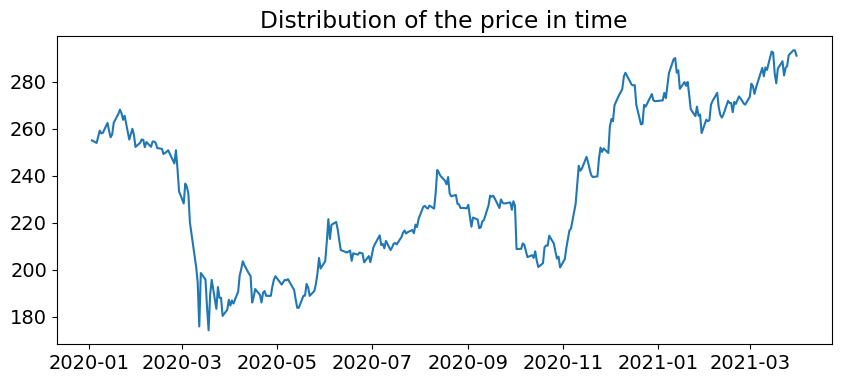

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(df_russia["Price"],label='Close Price history')
plt.title('Distribution of the price in time')

<Axes: >

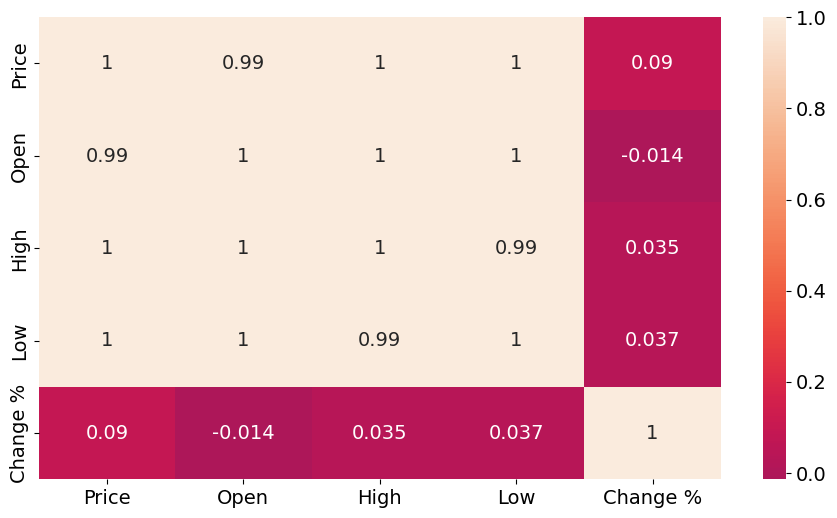

In [ ]:
plt.figure(figsize=(11,6)) # resizing the plot
sns.heatmap(df_russia.corr(),annot=True, cmap=sns.cm.rocket, center=0.117)

The same color is highly correlated which is low, high open and price. So we will be using Price for now.

In [ ]:
df = df_russia.copy()

In [ ]:
df_russia= df_russia.drop(['Open','Low','High','Change %', 'Vol.'], axis=1)

In [ ]:
df_russia.head()

,Price
Date,
2021-03-31,291.02
2021-03-30,293.25
2021-03-29,293.30
2021-03-26,291.22
2021-03-25,286.66


Testing for stationary


Time series only work with stationary objects we can test it with rooling statistics and the dickey-fuller test. If the mean and standard deviation is a straight line.



Rooling

In [ ]:
# computing a 7 day rolling average
rolling_mean= df_russia.Price.rolling(7).mean()
rolling_std= df_russia.Price.rolling(7).std()
# viewing the dataset
print('rolling_mean:', rolling_mean.head(9),'\n')
print('rolling_std:', rolling_std.head(9))

rolling_mean: Date
2021-03-31           NaN
2021-03-30           NaN
2021-03-29           NaN
2021-03-26           NaN
2021-03-25           NaN
2021-03-24           NaN
2021-03-23    289.120000
2021-03-22    288.781429
2021-03-19    287.670000
Name: Price, dtype: float64 

rolling_std: Date
2021-03-31         NaN
2021-03-30         NaN
2021-03-29         NaN
2021-03-26         NaN
2021-03-25         NaN
2021-03-24         NaN
2021-03-23    4.127150
2021-03-22    4.041631
2021-03-19    3.659672
Name: Price, dtype: float64


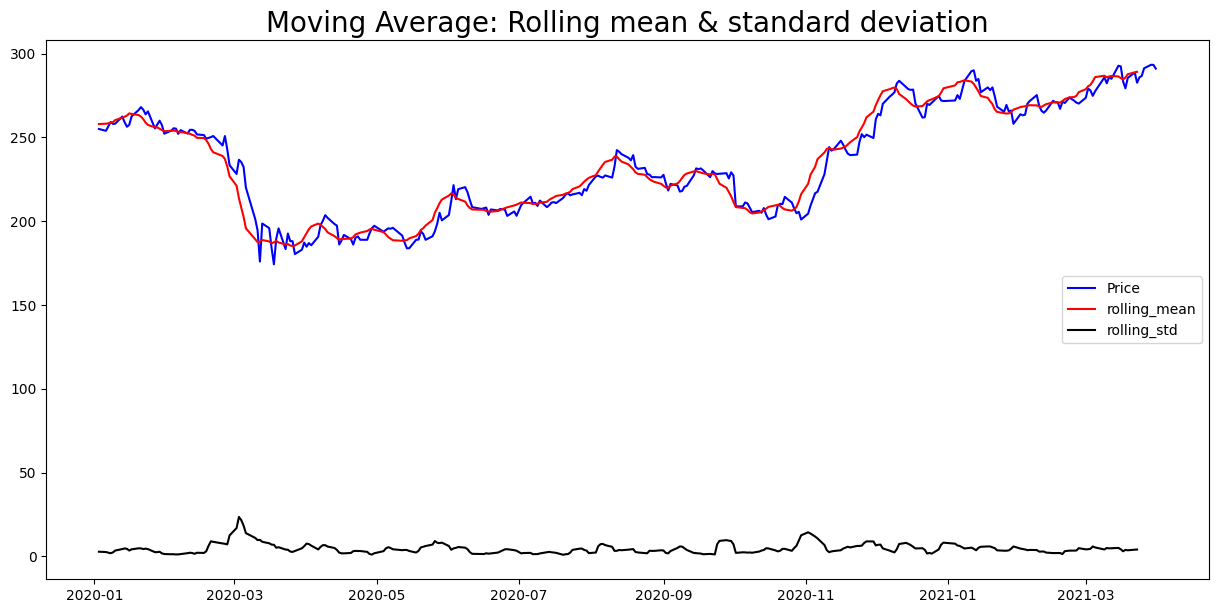

In [ ]:
plt.figure(figsize=(15,7))
orig=plt.plot(df_russia.Price, color='blue',label='Price')
R_mean=plt.plot(rolling_mean, color='red',label='rolling_mean')
R_std=plt.plot(rolling_std, color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Moving Average: Rolling mean & standard deviation',fontsize=20)
plt.show(block='False')

From above plot we can see that the mean and sd are not constant so we can say that they are not stationary.

DICKEY FULLER TEST

The Dickey-Fuller test is a stastical test used to assess whether a unit root is present in a time series dataset. It helps determine if a time series is stationary or exhibits a trend. A stationary time series has constant mean and variance over time, making it easier to analyze. The test involves comparing a calculated test stastic to critical values. If the test stastic is greater than the critical value, you fail to reject the null hypothesis of a unit root, suggesting non-stationary.

In [ ]:
print("Results of dickey fuller test")
adft = adfuller(df_russia.Price,autolag='AIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','Number of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -1.847182
p-value                          0.357301
Number of lags used              8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


Making data Stationary

One method for transforming the simplest non-stationary data is differencing. This process involves taking the differences of consecutive observations.
For simple distributions, taking the first-order difference.

In [ ]:
df_russia["diff_1"] = df_russia.Price.diff(periods=1)
df_russia.head()

,Price,diff_1
Date,,
2021-03-31,291.02,NaN
2021-03-30,293.25,2.23
2021-03-29,293.30,0.05
2021-03-26,291.22,-2.08
2021-03-25,286.66,-4.56


In [ ]:
results = adfuller(df_russia["diff_1"].dropna())
print('The new p-value is:',results[1])

The new p-value is: 4.3951775754216564e-07


The p-value is extremely small, proving that the transformation steps have shown their effect.We can confirm then the stationarity of the series.

<Axes: title={'center': 'The distribution of the new series'}, xlabel='Date'>

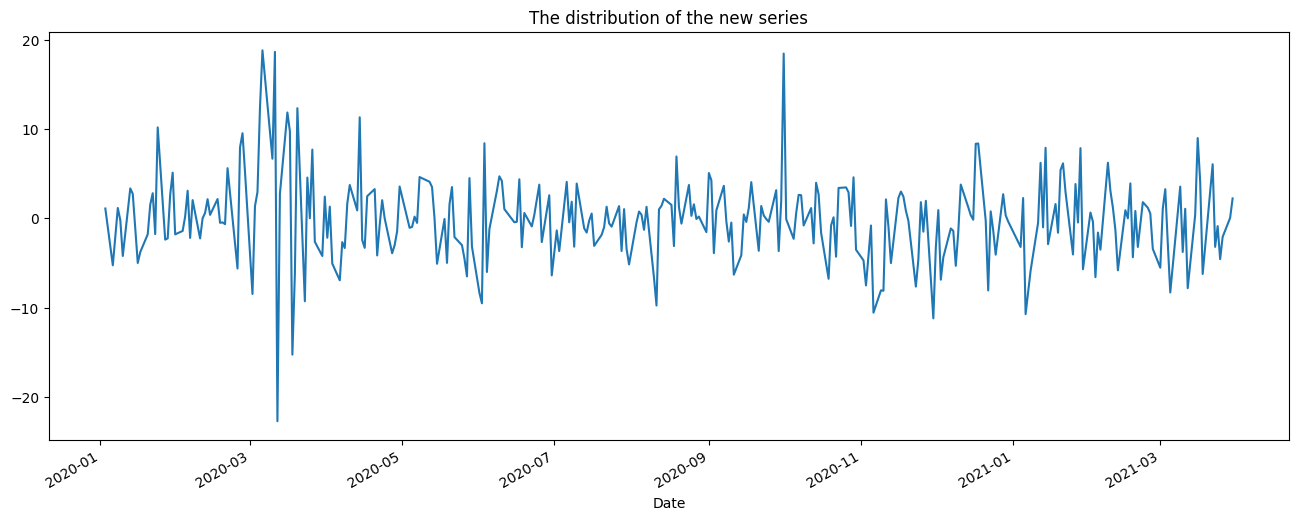

In [ ]:
plt.figure(figsize=(16,6))
plt.title("The distribution of the new series")
df_russia['diff_1'].plot()

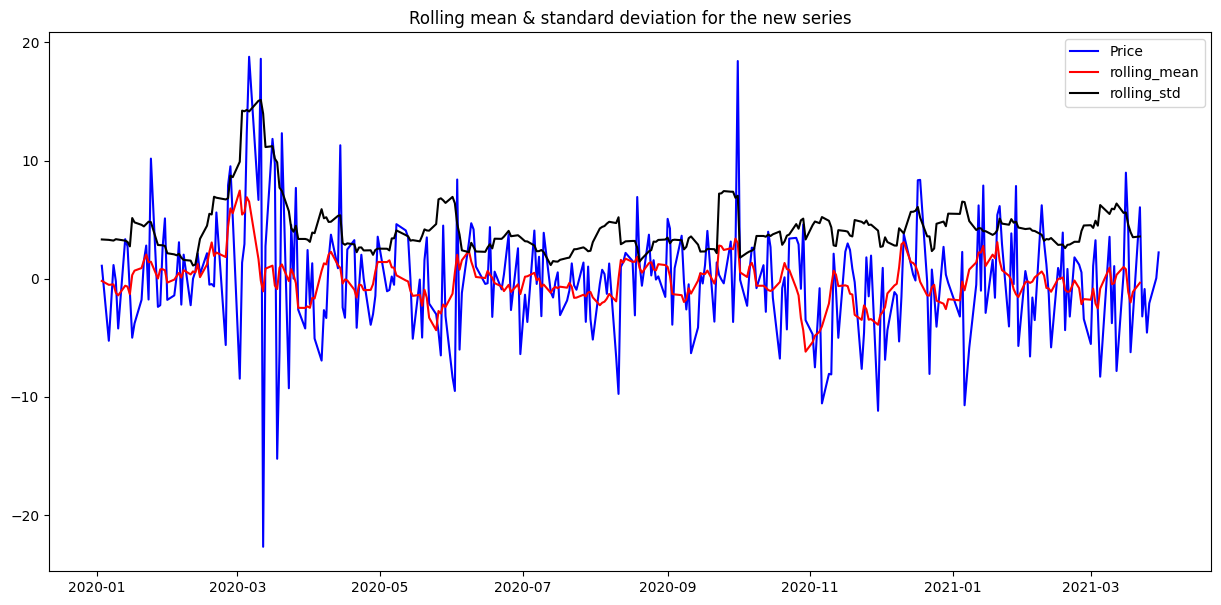

In [ ]:
#plot rolling statistics
plt.figure(figsize=(15,7))
orig=plt.plot(df_russia.diff_1, color='blue',label='Price')
R_mean=plt.plot(df_russia.diff_1.rolling(7).mean(), color='red',label='rolling_mean')
R_std=plt.plot(df_russia.diff_1.rolling(7).std(), color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation for the new series')
plt.show(block='False')

Forecasting

Time series forecasting allows us to predict future values in a time series given current and past data. Let's split first the dataset.We will use only till january 15 data and predict with the rest of the dates Q1 data.

In [ ]:
#split the data
np.random.seed(1)
train = df_russia[df_russia.index < pd.to_datetime('2021-01-15', format="%Y-%m-%d")]
#train=train.dropna()
test=df_russia[df_russia.index >= pd.to_datetime('2021-01-15', format="%Y-%m-%d")]
test=test.dropna()

In [ ]:
test.count()

Price    53
dtype: int64

In [ ]:
train.head()

,Price
Date,
2021-01-14,284.79
2021-01-13,283.78
2021-01-12,289.99
2021-01-11,289.49
2021-01-08,283.64


In [ ]:
test.head()

,Price
Date,
2021-03-31,291.02
2021-03-30,293.25
2021-03-29,293.30
2021-03-26,291.22
2021-03-25,286.66


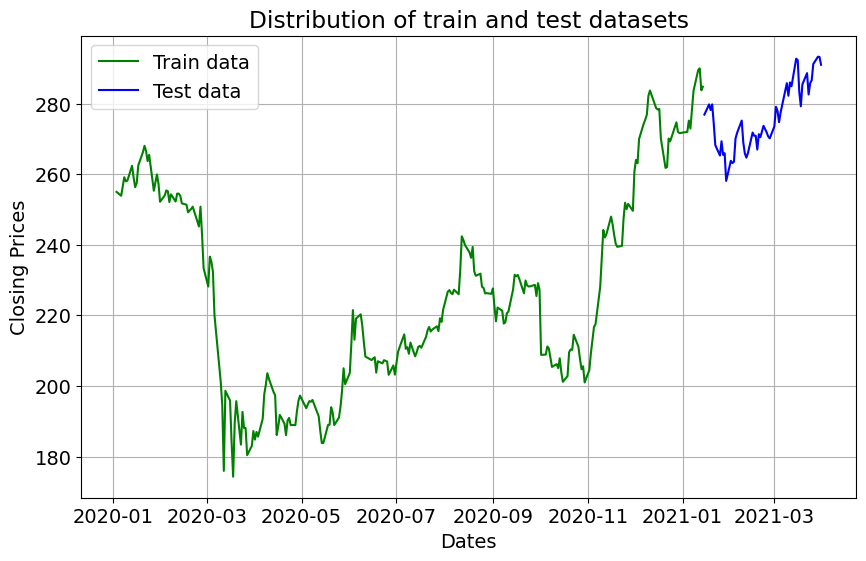

In [ ]:
#plot the distribution of train and test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.Price, 'green', label='Train data')
plt.plot(test.Price, 'blue', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

ARIMA Model

ARIMA is a popular time series forecasting model. It combnes autoregressive and moving average components with differencing to handle non-stationary data. The three main components of ARIMA are:
The notation for an ARIMA model is ARIMA(p, d, q), where:


*   p is the order of an AR component,
*   d is the degree of differencing,
*   q is the order of the MA component

Choosing apprppriate values for p. d, and q depends on the characteristics of the time series data. Model selection often involves analyzing autucorrelation and partial autocorrelation plots.





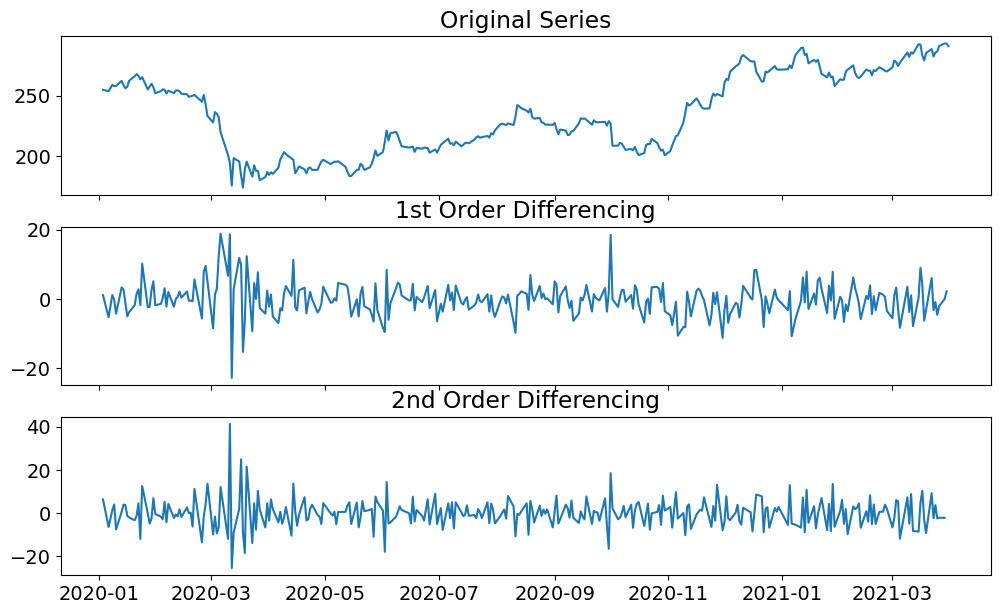

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df_russia.Price)
axes[0].set_title('Original Series')
#plot_acf(df1_russia.Price, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(df_russia.Price.diff())
axes[1].set_title('1st Order Differencing')
#plot_acf(df1_russia.Price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2].plot(df_russia.Price.diff().diff())
axes[2].set_title('2nd Order Differencing')
#plot_acf(df1_russia.Price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1851.634, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1853.469, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1853.451, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1849.819, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1855.348, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.589 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  311
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -923.909
Date:                Wed, 15 Nov 2023   AIC                           1849.819
Time:                        18:32:10   BIC                           1853.555
Sample:                             0   HQIC                          1851.313
               

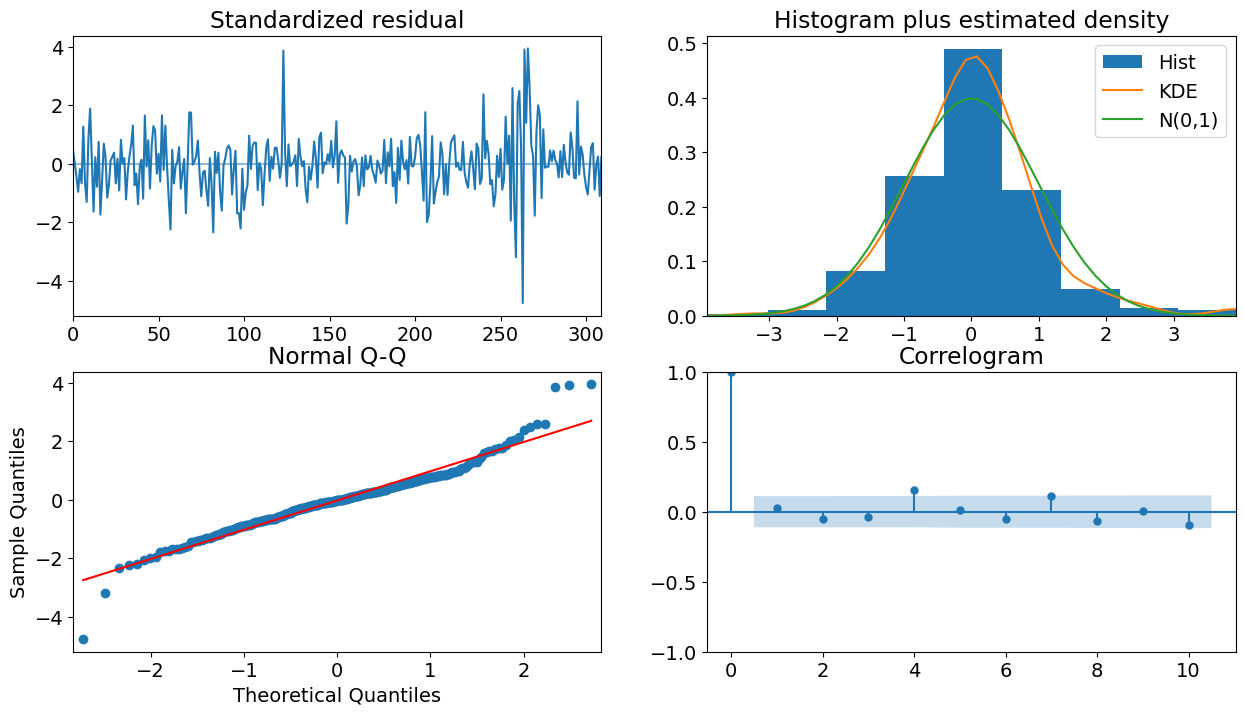

In [ ]:
model_autoARIMA = auto_arima(df_russia.Price,
                      trace=True,
                      suppress_warnings=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()



*  Standardize residual plot: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.


*  Normal Q-Q plot: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.
*   The density plot: The plot suggests a normal distribution with a mean of zero.

* The residual errors are not autocorrelated, as shown by the Correlogram,  also known as the ACF plot. Spikes are close to zero which is evidence against autocorrelation. So stock prices aren't highly correlated.



In [ ]:
model =  ARIMA(train.Price, order=(0,1,0))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  258
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -772.164
Date:                Wed, 15 Nov 2023   AIC                           1546.328
Time:                        18:32:25   BIC                           1549.877
Sample:                             0   HQIC                          1547.755
                                - 258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        23.8356      1.264     18.855      0.000      21.358      26.313
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               137.52
Prob(Q):                              0.49   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
model_1 = ARIMA(train.Price, order=(1,1,2))
model_1 = model_1.fit()
print(model_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  258
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -771.635
Date:                Wed, 15 Nov 2023   AIC                           1551.271
Time:                        18:32:48   BIC                           1565.467
Sample:                             0   HQIC                          1556.980
                                - 258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0330      0.996      0.033      0.974      -1.920       1.986
ma.L1          0.0127      1.006      0.013      0.990      -1.959       1.984
ma.L2         -0.0409      0.071     -0.578      0.5

In [ ]:
fc = model_1.forecast(53, alpha=0.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Typically, MAPE is used for evaluation it's a percentage errors that vary between 0 and 1. So, with a MAPE of around 7.5% from the results below, the model is 92.5% accurate in predicting the next 53 observations.



In [ ]:
mse = mean_squared_error(test.Price, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test.Price, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test.Price, fc))
print('RMSE: '+str(rmse))
#mape =np.mean (np.abs(fc - test.Price)/np.abs(test.Price))
mape =(np.mean(test.Price)-np.mean(fc))/np.mean(test.Price)
print('MAPE: '+str(mape))

MSE: 518.6774042398713
MAE: 20.836084617037958
RMSE: 22.77449020812258
MAPE: 0.07547716810399605


LSTM


Long short-term memory (LSTM) is recurrent neural network (RNN) architecture used in the field of deep learning. It is well suited for time series forecasting, natural language processing and speech recognition. Unlike standard feedforward neural networks, LSTM has feedback connections. It can be used with single data points such as image and entire sequences of data such as speech.
I'm going to build a multi-layer LSTM recurrent neural network to predict the last value of a sequence of values

In [ ]:
df_russia.head()

,Price
Date,
2021-03-31,291.02
2021-03-30,293.25
2021-03-29,293.30
2021-03-26,291.22
2021-03-25,286.66


In [ ]:
df_russia.tail()

,Price
Date,
2020-01-10,258.19
2020-01-09,257.99
2020-01-08,259.15
2020-01-06,253.90
2020-01-03,255.00


In [ ]:
np.random.seed(1)
train_LSTM = df_russia[df_russia.index < pd.to_datetime('2021-01-15', format="%Y-%m-%d")]
train_LSTM=train_LSTM.dropna()
test_LSTM=df_russia[df_russia.index >= pd.to_datetime('2021-01-15', format="%Y-%m-%d")]
test_LSTM=test_LSTM.dropna()

In [ ]:
print('shape of train set: ',str(train_LSTM.shape[0]))
print('shape of test set: ',test_LSTM.shape)

shape of train set:  258
shape of test set:  (53, 1)


In [ ]:
def build_train_test_normalize(time_steps,for_periods):
    np.random.seed(1)
    # create training and test set
    ts_train = train_LSTM.iloc[:,0:1].values
    ts_test  = test_LSTM.iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((train_LSTM.iloc[:,0:1], test_LSTM.iloc[:,0:1]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

We have reshaped the data into the following format (values, time-steps, dimensional).
Now, it’s time to build the model. We will build the LSTM with 120 neurons and 5 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer.



In [ ]:
X_train, y_train, X_test, sc = build_train_test_normalize(7,1)
X_train.shape[0],X_train.shape[1]

(250, 7)

In [ ]:
#define plot function
def actual_vs_pred_plot(preds, data=test_LSTM, plot=True):
    #define a new dataframe with price and prediction columns

    actual_pred = pd.DataFrame(columns = ['Price', 'prediction'])
    actual_pred['Price'] = data.iloc[:,0:1].iloc[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    MAPE=np.mean(np.abs(np.array(actual_pred['prediction'])- np.array(actual_pred['Price']))/np.abs(np.array(actual_pred['Price'])))
    RMSE=math.sqrt(mean_squared_error(np.array(actual_pred['Price']), np.array(actual_pred['prediction'])))
    if plot==True:
        actual_pred.plot()
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    return MAPE,RMSE

In [ ]:
#create a LSTM model
def LSTM_model_fc(X_train, y_train, X_test, sc, epoch=100, batch_size=32,optimizer='Adam',units=120):
    np.random.seed(1)
    regressor = Sequential()
    regressor.add(LSTM(units=units, return_sequences=True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=units))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['accuracy'])
    regressor.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)
    LSTM_prediction = regressor.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return regressor, LSTM_prediction

In [ ]:
np.random.seed(1)
#choose a time step of 7 days and a preiod of 1 predictions
X_train, y_train, X_test, sc = build_train_test_normalize(7,1)
X_train.shape[0],X_train.shape[1]
LSTM_model, LSTM_prediction = LSTM_model_fc(X_train, y_train, X_test, sc)

Epoch 1/100
8/8 [==============================] - 18s 174ms/step - loss: 0.1338 - accuracy: 0.0040
Epoch 2/100
8/8 [==============================] - 1s 116ms/step - loss: 0.0460 - accuracy: 0.0040
Epoch 3/100
8/8 [==============================] - 1s 147ms/step - loss: 0.0328 - accuracy: 0.0040
Epoch 4/100
8/8 [==============================] - 1s 108ms/step - loss: 0.0240 - accuracy: 0.0040
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0150 - accuracy: 0.0040
Epoch 6/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0129 - accuracy: 0.0040
Epoch 7/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0140 - accuracy: 0.0040
Epoch 8/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0116 - accuracy: 0.0040
Epoch 9/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0114 - accuracy: 0.0040
Epoch 10/100
8/8 [==============================] - 1s 116ms/step - loss: 0.0115 - accuracy: 0.0040
Epoch 11

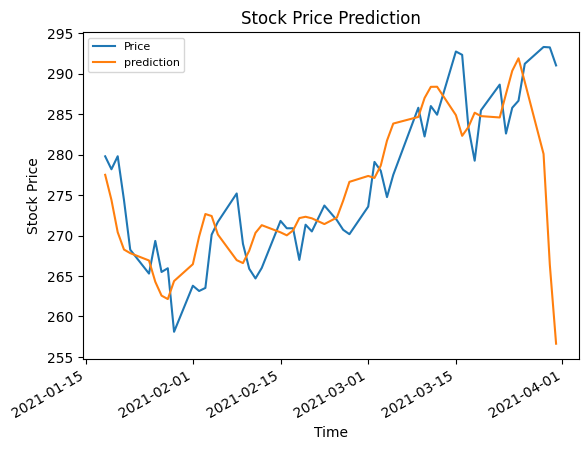

(0.018032065150359603, 7.758115749501849)

In [ ]:
actual_vs_pred_plot(LSTM_prediction)

**Bollinger bands**

Bollinger Bands are a technical analysis tool commonly used in financial markets, such as stock trading, to visualize price volatility and identity potential trend reversals. The higher the volatility, the wider the bands. They are usually drawn in this way:



*  Higher band: a 20-period Simple Moving Average plus 2 times the 20-period rolling standard deviation, both calculated on the close price
*  Lower band: a 20-period Simple Moving Average minus 2 times the 20-period rolling standard deviation, both calculated on the close price




Bollinger Bands have 2 parameter the period used for the moving average and the multiplier determining the width of the bands.

These bands help traders assess whether an asset is overbought or oversold. When the price touches or crosses the upper band, the assest may be overbought, indicating a potential sell signal. Similarly the opposite when the prices crosses the lower band assest may be oversold so buy signal is given.

In [ ]:
df_bands=train_LSTM[['Price']]

In [ ]:
period = 20
multiplier = 2

In [ ]:
df_bands['UpperBand'] = df_bands['Price'].rolling(period).mean() + df_bands['Price'].rolling(period).std() * multiplier
df_bands['LowerBand'] = df_bands['Price'].rolling(period).mean() - df_bands['Price'].rolling(period).std() * multiplier

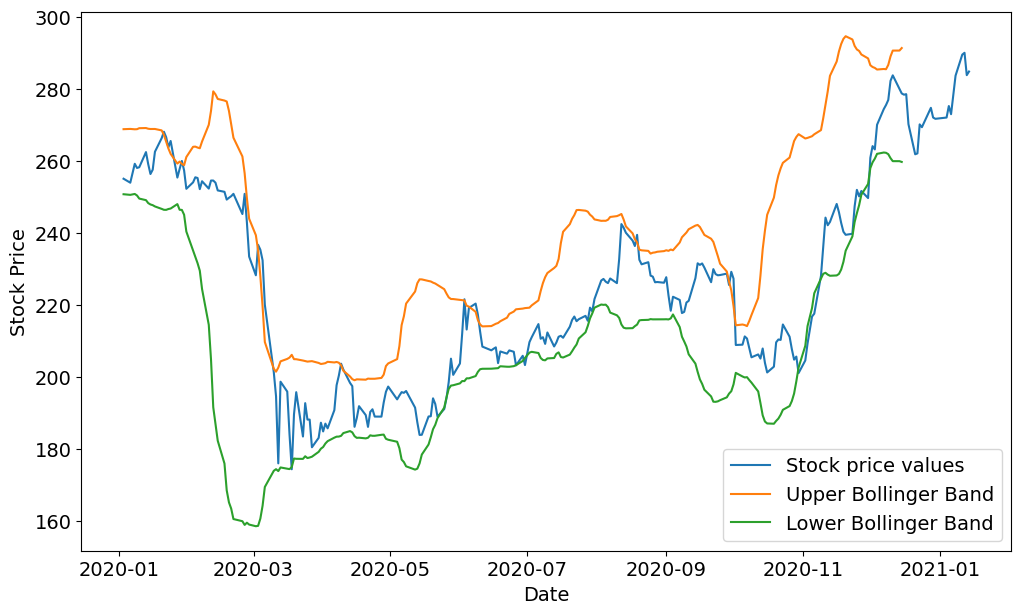

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14)

plt.plot(df_bands['Price'], label = "Stock price values")
plt.plot(df_bands['UpperBand'], label = "Upper Bollinger Band")
plt.plot(df_bands['LowerBand'], label = "Lower Bollinger Band")

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
y_train_pred=LSTM_model.predict(X_train)
y_train_pred = sc.inverse_transform(y_train_pred)

8/8 [==============================] - 0s 18ms/step


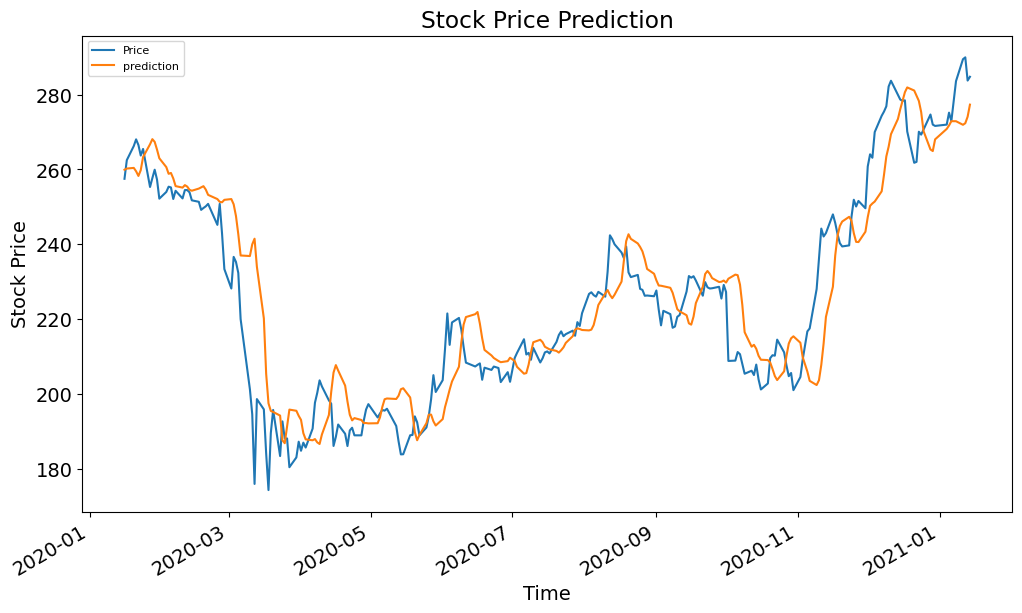

(0.039704807890551565, 11.929355376140379)

In [ ]:
actual_vs_pred_plot(y_train_pred, train_LSTM)

In [ ]:
label_stocks = pd.DataFrame(columns = ['real', 'pred','label'])
label_stocks['real'] = train_LSTM.iloc[:,0:1].iloc[0:len(y_train_pred)]
label_stocks['pred'] = y_train_pred[:,0]

In [ ]:
label_stocks=label_stocks.sort_values(by='Date')
label_stocks.head(5)

,real,pred,label
Date,,,
2020-01-16,257.51,259.931519,NaN
2020-01-17,262.50,260.251465,NaN
2020-01-20,266.28,260.424744,NaN
2020-01-21,268.06,259.521210,NaN
2020-01-22,266.54,258.272888,NaN


In [ ]:
# 0 hold , 1 buy, 2 sell

label_stocks["label"][0]='hold'
for i in range(1,label_stocks.shape[0]):
    if label_stocks['pred'][i]< label_stocks['real'][i]:
        label_stocks["label"][i]='sell'
        diff=0
    elif label_stocks['pred'][i]> label_stocks['real'][i]:
        label_stocks["label"][i]='buy'
        diff=1

    else:
        label_stocks["label"][i]='hold'


In [ ]:
# recommendation of buy
label_stocks[label_stocks["label"]=='buy']

,real,pred,label
Date,,,
2020-01-27,255.32,266.747467,buy
2020-01-28,257.70,268.110107,buy
2020-01-29,259.94,267.383514,buy
2020-01-30,257.31,265.324127,buy
2020-01-31,252.20,262.997253,buy
...,...,...,...
2020-12-18,270.16,281.944122,buy
2020-12-21,261.79,281.118835,buy
2020-12-22,262.04,279.709442,buy


In [ ]:
label_stocks[label_stocks["label"]=='sell']

,real,pred,label
Date,,,
2020-01-17,262.50,260.251465,sell
2020-01-20,266.28,260.424744,sell
2020-01-21,268.06,259.521210,sell
2020-01-22,266.54,258.272888,sell
2020-01-23,263.73,259.823822,sell
...,...,...,...
2021-01-08,283.64,272.907562,sell
2021-01-11,289.49,271.951630,sell
2021-01-12,289.99,272.376587,sell


In [ ]:
label_stocks[label_stocks["label"]=='hold']

,real,pred,label
Date,,,
2020-01-16,257.51,259.931519,hold


From  the results above, we can notice that ARIMA was the accurat model with an MAPE= 0.07547716810399605. We can see that the stastics model ARIMA performs well than deep learning model which is LSTM. The deep learning needs more data for training to get an accurate data. Also so according to the situation we should select the appropriate model.

